# Phase 5: Evaluation — Advanced Visualization

**Project**: PequeShop EDA — Exploratory Data Analysis for Commercial Decisions  
**Author**: Jose Marcel Lopez Pino  
**Date**: 2026-02-19  
**Framework**: CRISP-DM + Lean  
**Module**: 4 — Exploratory Data Analysis (Bootcamp SENCE/Alkemy)  

---

## Context

This notebook is Phase 5 (Evaluation) of the PequeShop analytics project.  
It builds on the statistical analysis from Phase 4 (04_modeling.ipynb)  
and presents findings through advanced visualizations.

## Module 4 Lessons Covered

| Lesson | Topic | Section |
|--------|-------|---------|
| L5 | Visual Data Analysis (Seaborn) | 5.1 |
| L6 | Matplotlib Library | 5.2 |

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats

# Project imports
import sys
sys.path.append('..')
from config.config import DATA_RAW, FIGURES

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.dpi'] = 150

%matplotlib inline

print('Libraries loaded successfully.')

Libraries loaded successfully.


## 5.0 Load Data

In [2]:
# =============================================================================
# LOAD DATA (same as Phase 4)
# =============================================================================

df_customers = pd.read_csv(DATA_RAW / 'customers_final.csv')
df_transactions = pd.read_csv(DATA_RAW / 'transactions_final.csv')

# Parse dates
for col in ['registration_date', 'first_purchase', 'last_purchase']:
    df_customers[col] = pd.to_datetime(df_customers[col], errors='coerce')
df_transactions['transaction_date'] = pd.to_datetime(
    df_transactions['transaction_date'], errors='coerce'
)

# Derived subsets
active_customers = df_customers.dropna(subset=['total_transactions'])
nps_respondents = df_customers.dropna(subset=['nps_score'])
df_complete = active_customers.dropna(subset=['nps_score'])

print(f'Customers: {len(df_customers)} | Active: {len(active_customers)} | '
      f'NPS respondents: {len(nps_respondents)}')
print(f'Transactions: {len(df_transactions)}')

Customers: 500 | Active: 392 | NPS respondents: 235
Transactions: 1192


---

## 5.1 Visual Data Analysis with Seaborn (Lesson 5)

### 5.1.1 Pairplot — Multi-variable Overview

**Business question**: How do transaction variables relate to each other,  
and do patterns differ by platform?

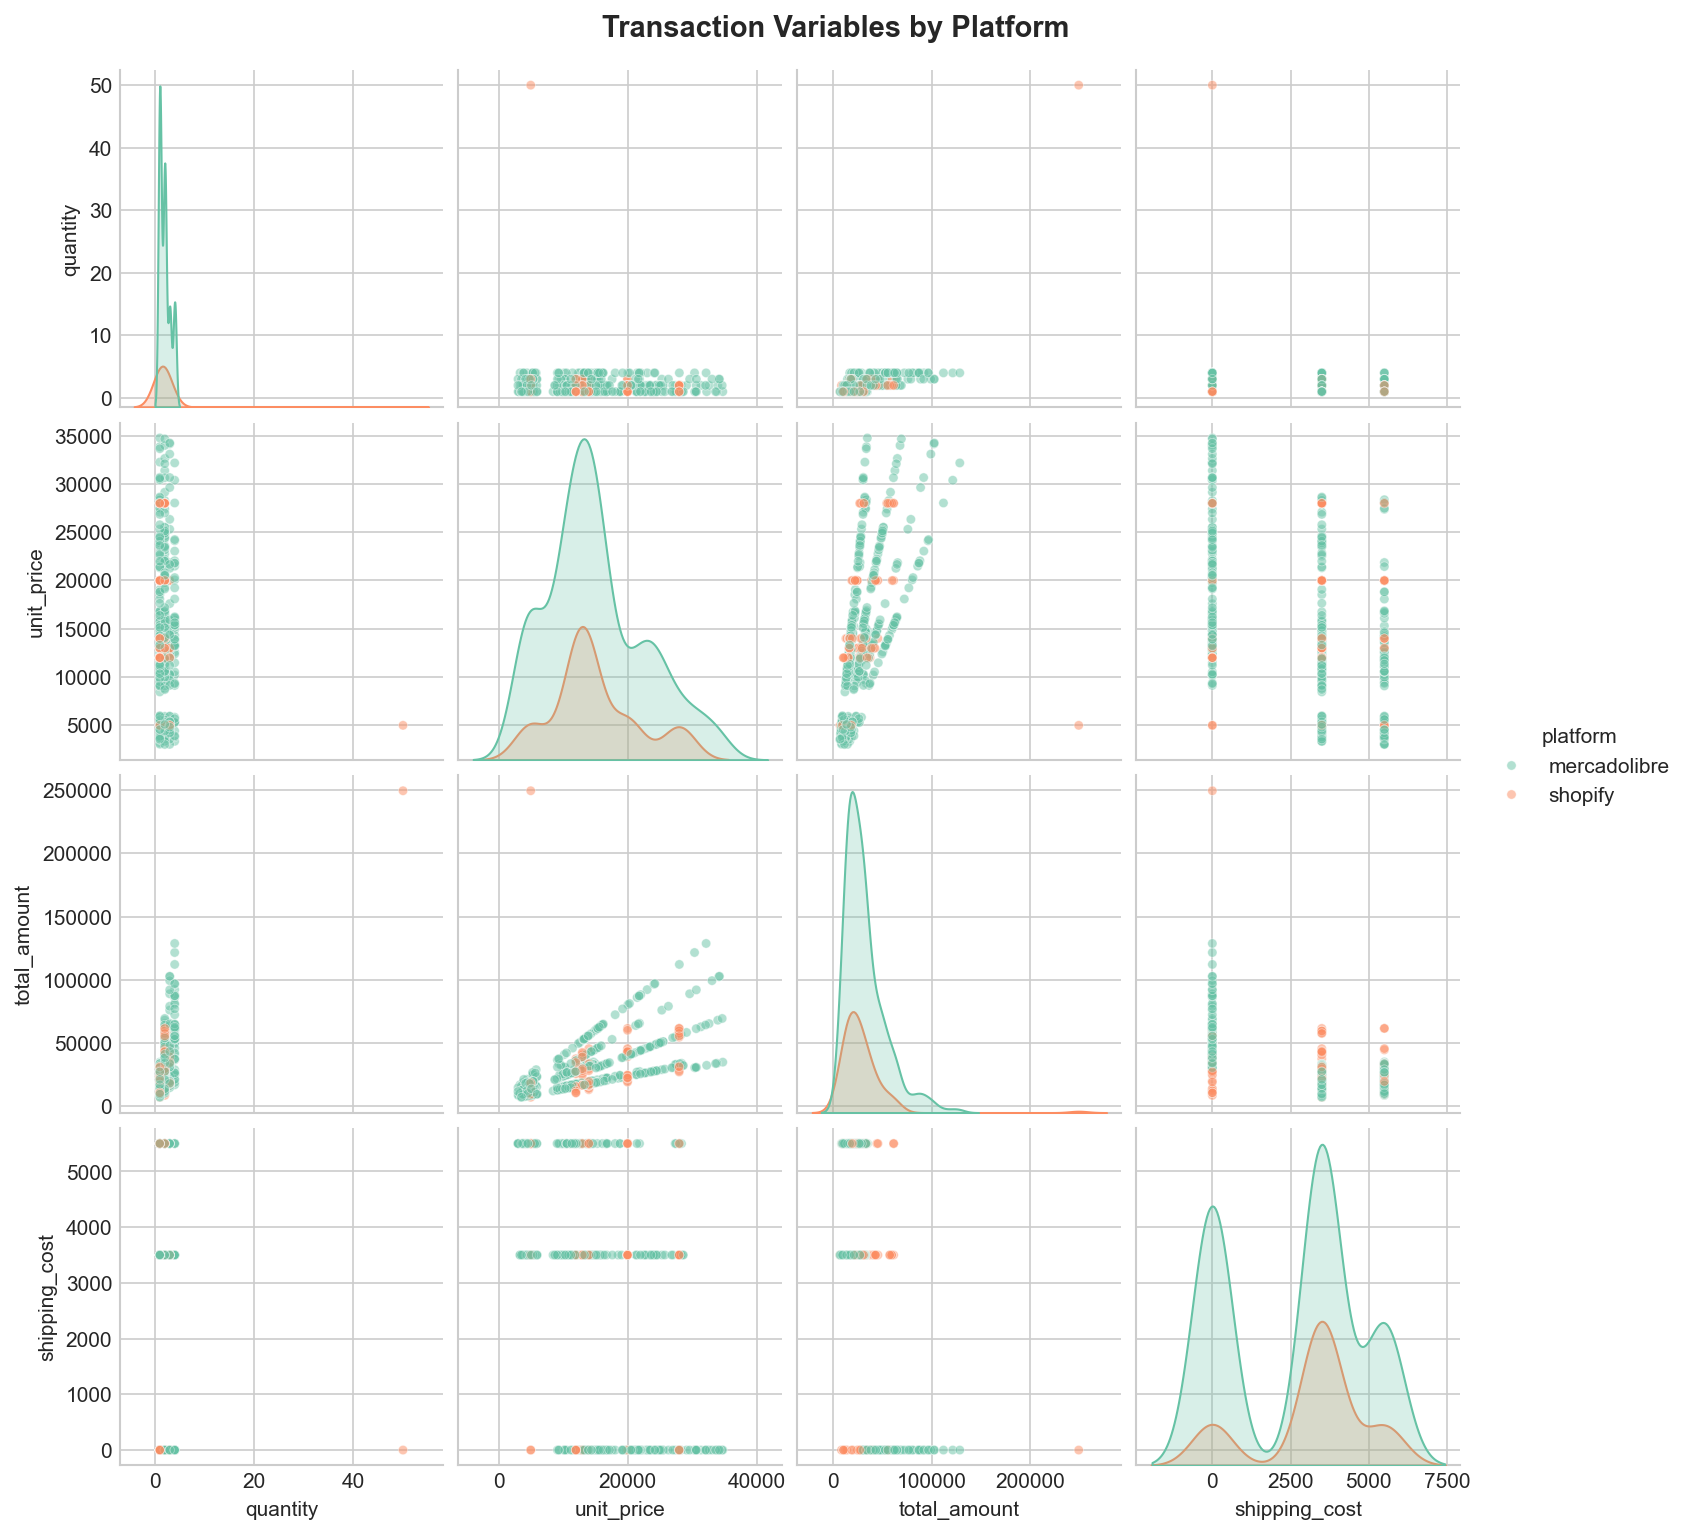

Figure saved: reports/figures/pairplot_transactions.png


In [3]:
# =============================================================================
# PAIRPLOT — TRANSACTION VARIABLES BY PLATFORM
# =============================================================================

pairplot_cols = ['quantity', 'unit_price', 'total_amount', 'shipping_cost', 'platform']

# Sample for readability (pairplot with 1192 points gets dense)
df_sample = df_transactions[pairplot_cols].sample(n=500, random_state=42)

g = sns.pairplot(
    df_sample,
    hue='platform',
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 20},
    height=2.5
)
g.figure.suptitle('Transaction Variables by Platform', y=1.02,
                  fontsize=14, fontweight='bold')

g.savefig(FIGURES / 'pairplot_transactions.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/pairplot_transactions.png')

### 5.1.2 Violinplot — Distribution Comparison

**Business question**: How does revenue distribution differ across  
customer segments? Are some segments more consistent than others?

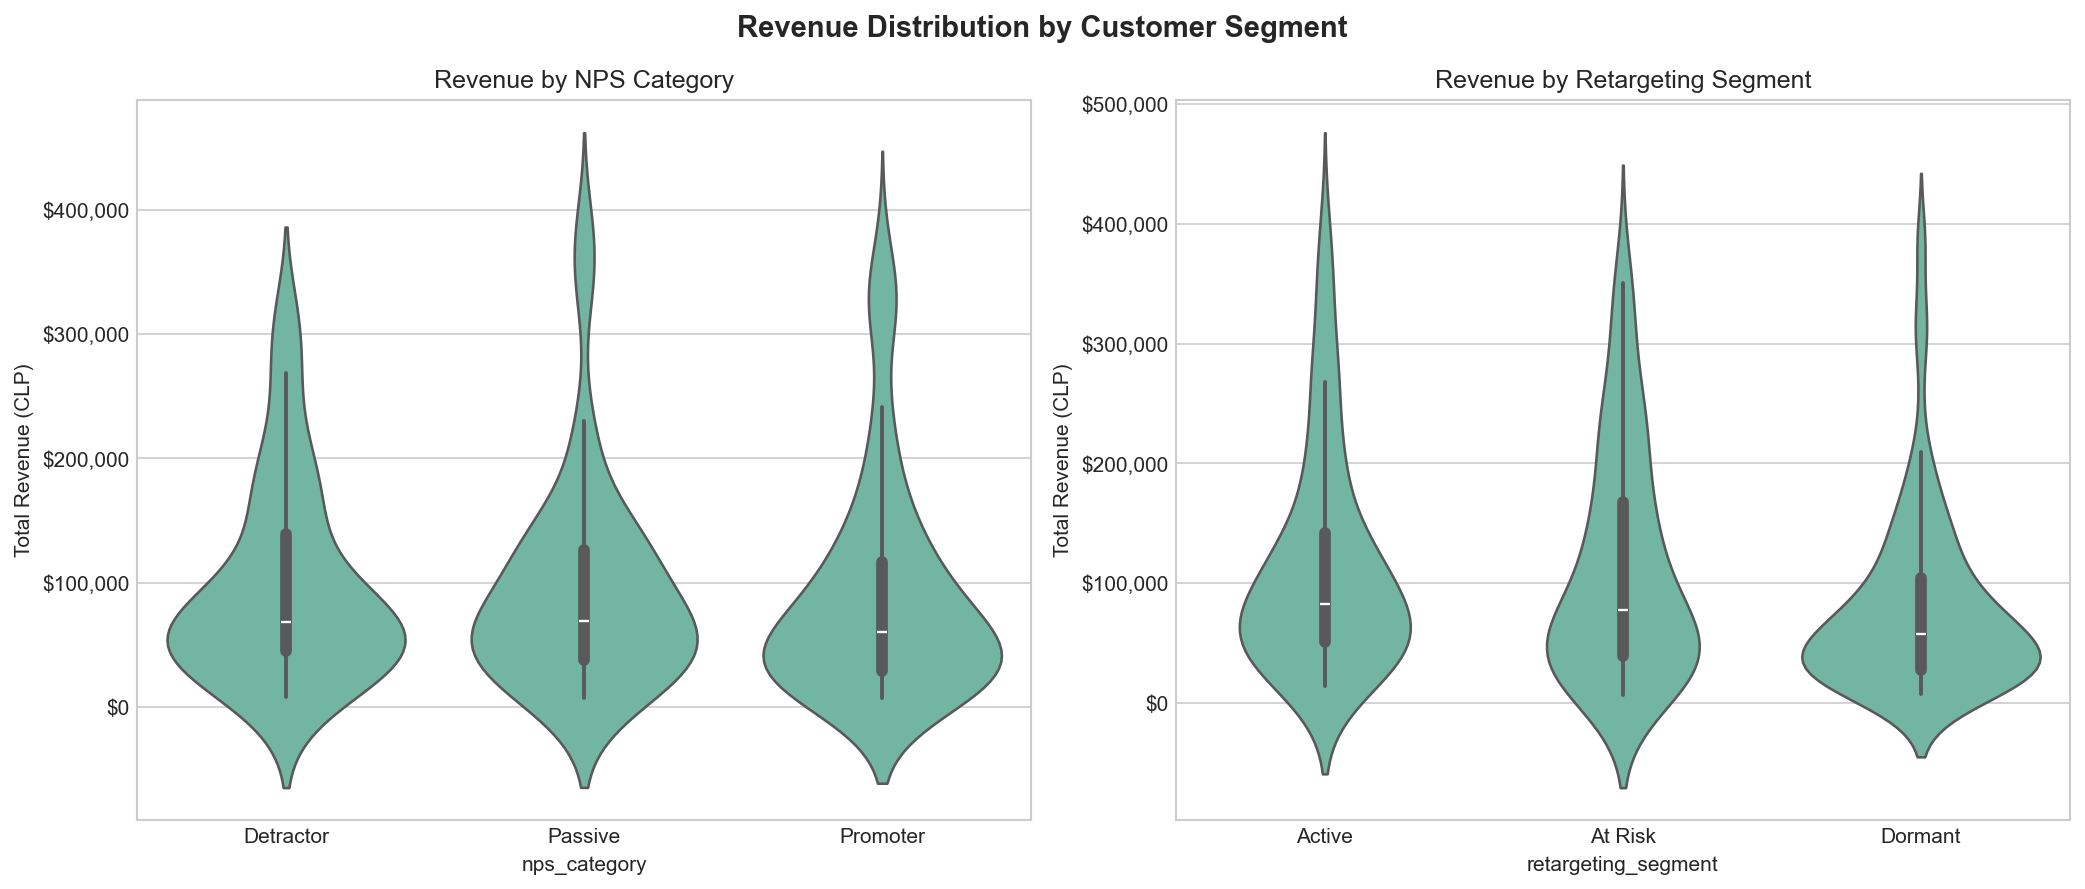

Figure saved: reports/figures/violinplots_revenue.png


In [4]:
# =============================================================================
# VIOLINPLOT — REVENUE BY NPS CATEGORY
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Revenue Distribution by Customer Segment',
             fontsize=14, fontweight='bold')

# By NPS category
order_nps = ['Detractor', 'Passive', 'Promoter']
sns.violinplot(
    data=df_complete,
    x='nps_category',
    y='total_revenue',
    order=order_nps,
    inner='box',
    ax=axes[0]
)
axes[0].set_title('Revenue by NPS Category')
axes[0].set_ylabel('Total Revenue (CLP)')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x:,.0f}'
))

# By retargeting segment
order_seg = ['Active', 'At Risk', 'Dormant']
sns.violinplot(
    data=active_customers,
    x='retargeting_segment',
    y='total_revenue',
    order=order_seg,
    inner='box',
    ax=axes[1]
)
axes[1].set_title('Revenue by Retargeting Segment')
axes[1].set_ylabel('Total Revenue (CLP)')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x:,.0f}'
))

plt.tight_layout()
fig.savefig(FIGURES / 'violinplots_revenue.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/violinplots_revenue.png')

### 5.1.3 Jointplot — Bivariate Analysis

**Business question**: What is the joint distribution of  
quantity and unit price? Where do most transactions cluster?

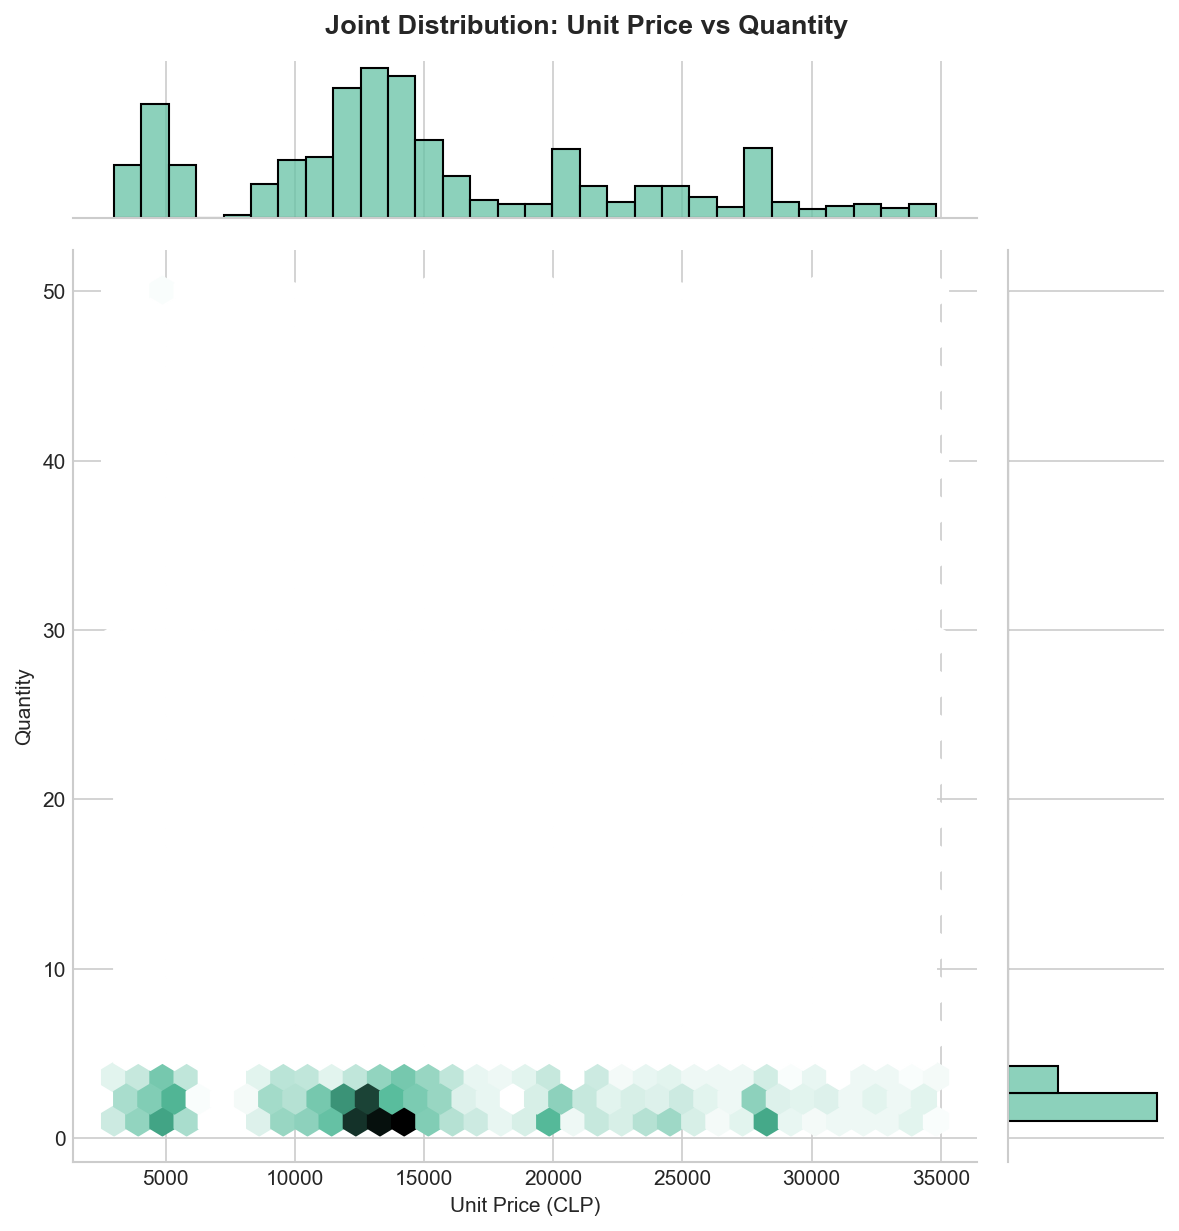

Figure saved: reports/figures/jointplot_price_quantity.png


In [5]:
# =============================================================================
# JOINTPLOT — QUANTITY vs UNIT PRICE
# =============================================================================

g = sns.jointplot(
    data=df_transactions,
    x='unit_price',
    y='quantity',
    kind='hex',
    height=8,
    marginal_kws={'bins': 30}
)
g.figure.suptitle('Joint Distribution: Unit Price vs Quantity',
                  y=1.02, fontsize=13, fontweight='bold')
g.set_axis_labels('Unit Price (CLP)', 'Quantity')

g.savefig(FIGURES / 'jointplot_price_quantity.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/jointplot_price_quantity.png')

### 5.1.4 Heatmap — Revenue by Product and Season

**Business question**: Which product-season combinations generate  
the most revenue? This informs inventory and marketing planning.

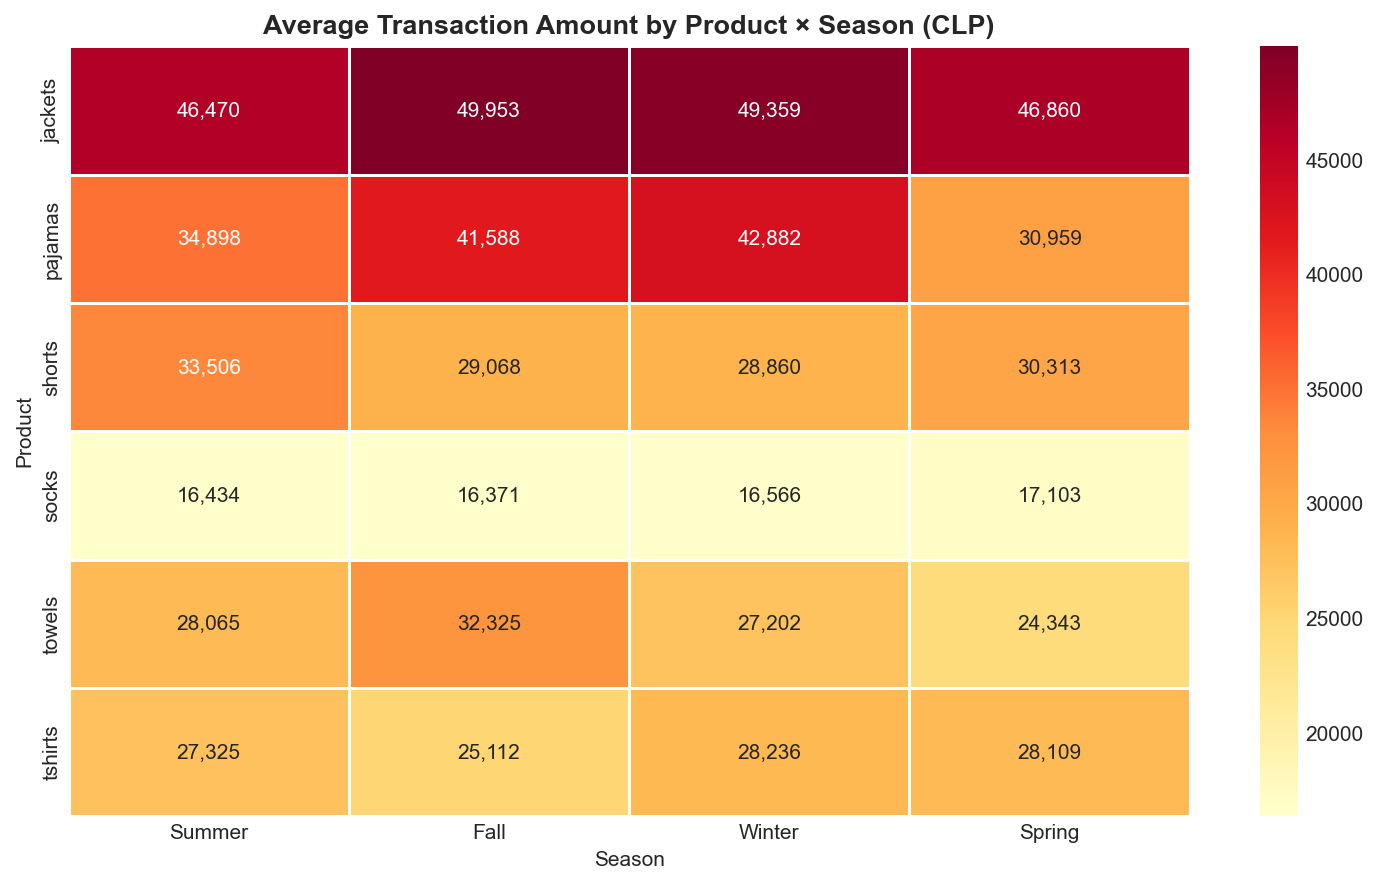

Figure saved: reports/figures/heatmap_product_season.png


In [6]:
# =============================================================================
# HEATMAP — REVENUE BY PRODUCT AND SEASON
# =============================================================================

# Pivot table: average revenue per transaction by product and season
season_order = ['Summer', 'Fall', 'Winter', 'Spring']
pivot_revenue = df_transactions.pivot_table(
    values='total_amount',
    index='product',
    columns='season',
    aggfunc='mean'
)[season_order]

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    pivot_revenue,
    annot=True,
    fmt=',.0f',
    cmap='YlOrRd',
    linewidths=0.5,
    ax=ax
)
ax.set_title('Average Transaction Amount by Product × Season (CLP)',
             fontsize=13, fontweight='bold')
ax.set_ylabel('Product')
ax.set_xlabel('Season')

plt.tight_layout()
fig.savefig(FIGURES / 'heatmap_product_season.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/heatmap_product_season.png')

### 5.1.5 FacetGrid — Segmented Analysis

**Business question**: How does the relationship between quantity  
and total amount differ across product categories?

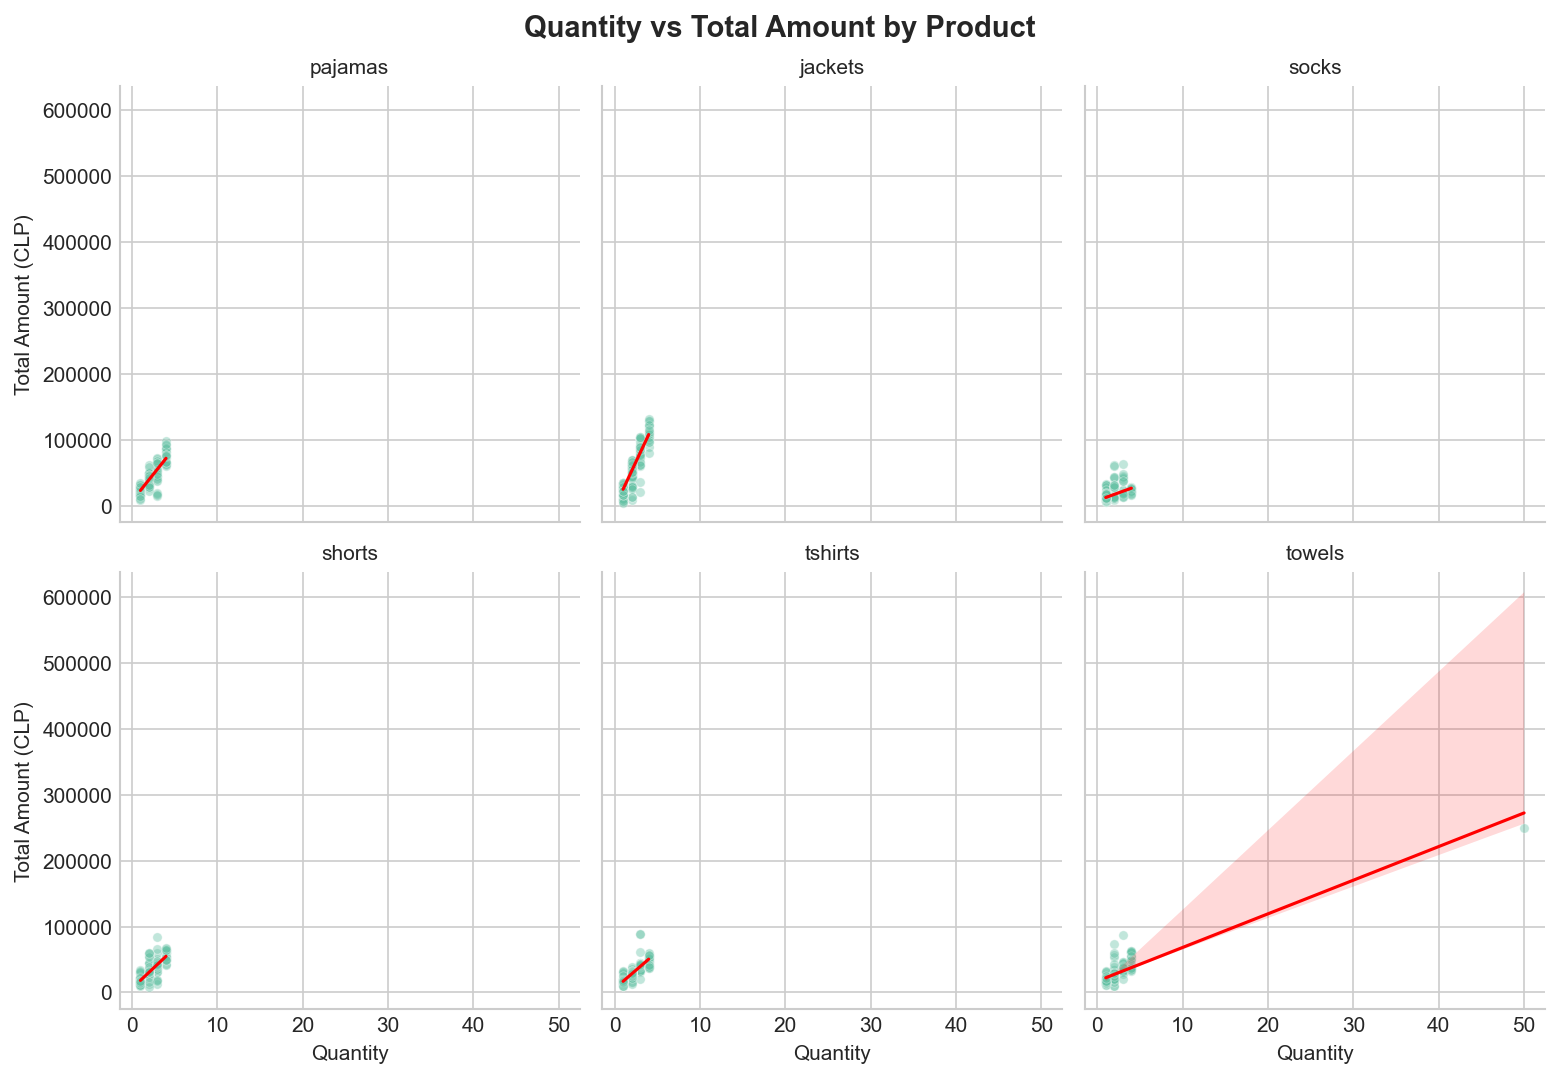

Figure saved: reports/figures/facetgrid_product_regression.png


In [7]:
# =============================================================================
# FACETGRID — QUANTITY vs TOTAL AMOUNT BY PRODUCT
# =============================================================================

g = sns.FacetGrid(
    df_transactions,
    col='product',
    col_wrap=3,
    height=3.5,
    sharex=True,
    sharey=True
)
g.map_dataframe(sns.scatterplot, x='quantity', y='total_amount', alpha=0.4, s=20)
g.map_dataframe(sns.regplot, x='quantity', y='total_amount',
                scatter=False, color='red', line_kws={'linewidth': 1.5})
g.set_axis_labels('Quantity', 'Total Amount (CLP)')
g.set_titles(col_template='{col_name}')
g.figure.suptitle('Quantity vs Total Amount by Product',
                  y=1.02, fontsize=14, fontweight='bold')

g.savefig(FIGURES / 'facetgrid_product_regression.png',
          bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/facetgrid_product_regression.png')

### 5.1.6 Countplot and Boxplot — Categorical Analysis

**Business question**: Which acquisition channels bring  
the most customers, and which bring the highest-value ones?

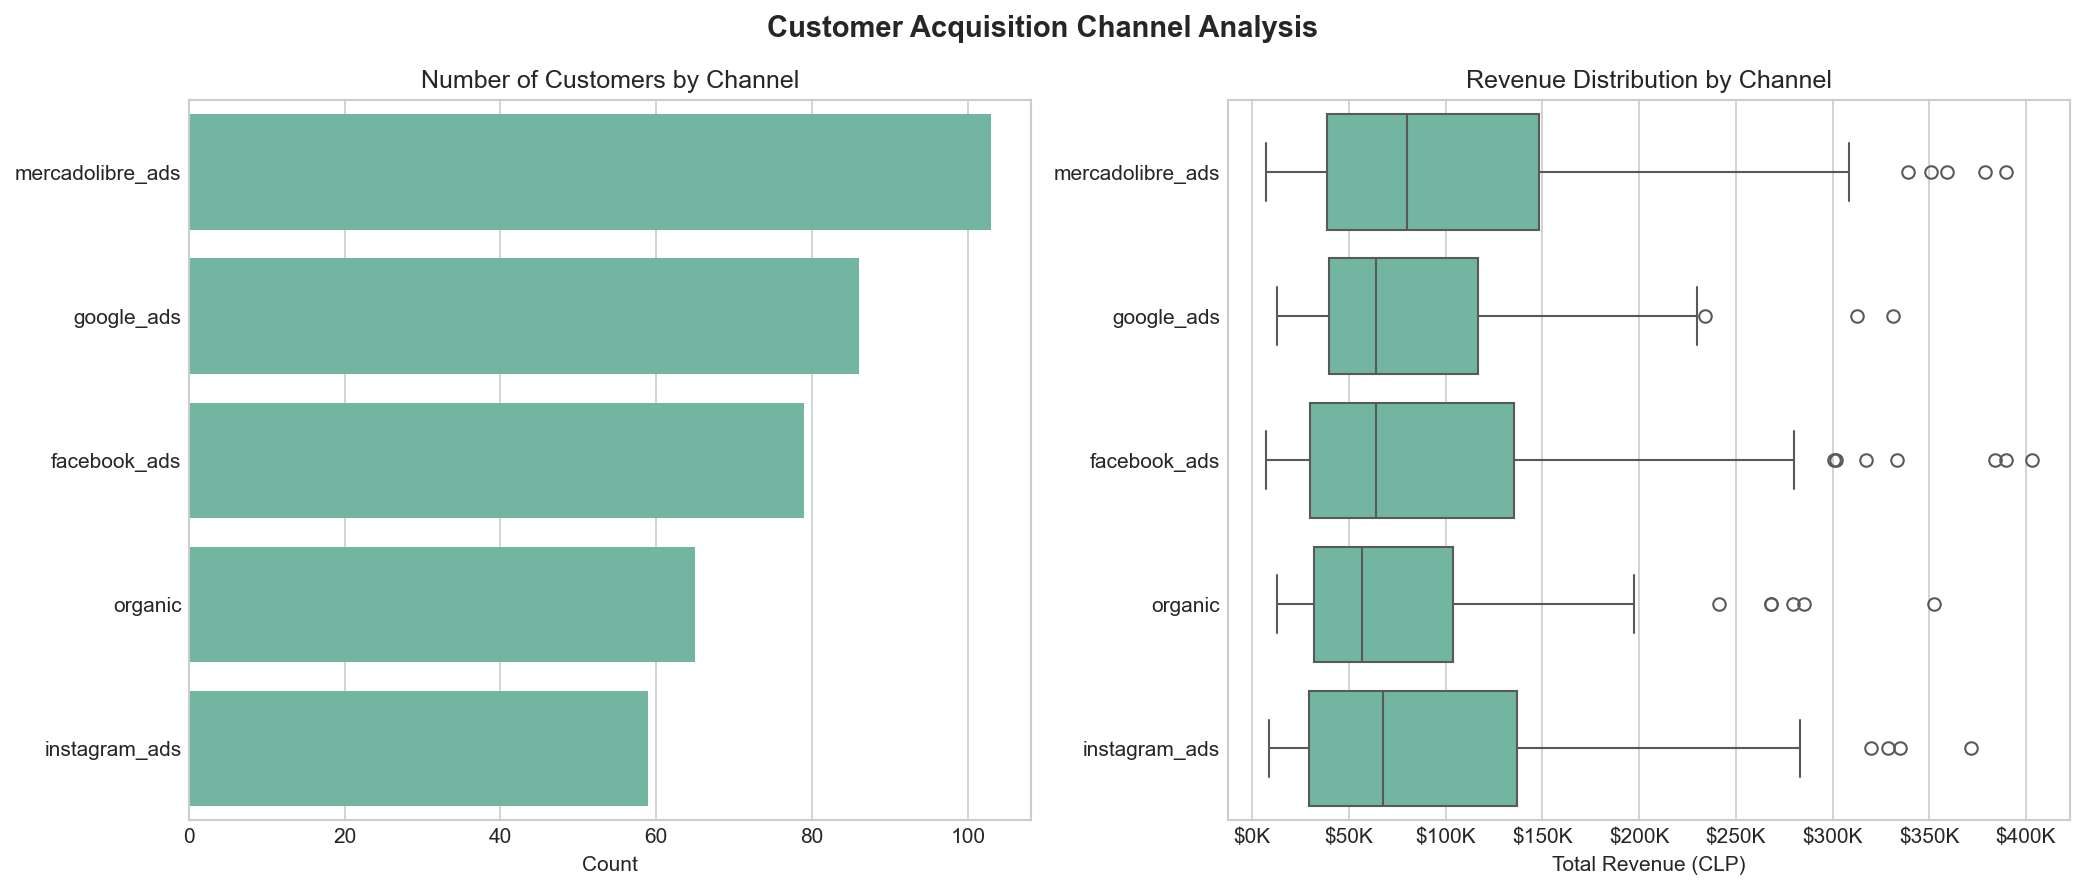

Figure saved: reports/figures/channel_analysis.png


In [8]:
# =============================================================================
# COUNTPLOT + BOXPLOT — ACQUISITION CHANNELS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Customer Acquisition Channel Analysis',
             fontsize=14, fontweight='bold')

# Volume by channel
channel_order = (
    active_customers['acquisition_channel']
    .value_counts()
    .index
    .tolist()
)
sns.countplot(
    data=active_customers,
    y='acquisition_channel',
    order=channel_order,
    ax=axes[0]
)
axes[0].set_title('Number of Customers by Channel')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('')

# Revenue by channel
sns.boxplot(
    data=active_customers,
    y='acquisition_channel',
    x='total_revenue',
    order=channel_order,
    ax=axes[1]
)
axes[1].set_title('Revenue Distribution by Channel')
axes[1].set_xlabel('Total Revenue (CLP)')
axes[1].set_ylabel('')
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x/1000:,.0f}K'
))

plt.tight_layout()
fig.savefig(FIGURES / 'channel_analysis.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/channel_analysis.png')

---

## 5.2 Custom Visualizations with Matplotlib (Lesson 6)

### 5.2.1 Executive Dashboard — Subplots

A single figure that tells the complete PequeShop story  
for the executive team.

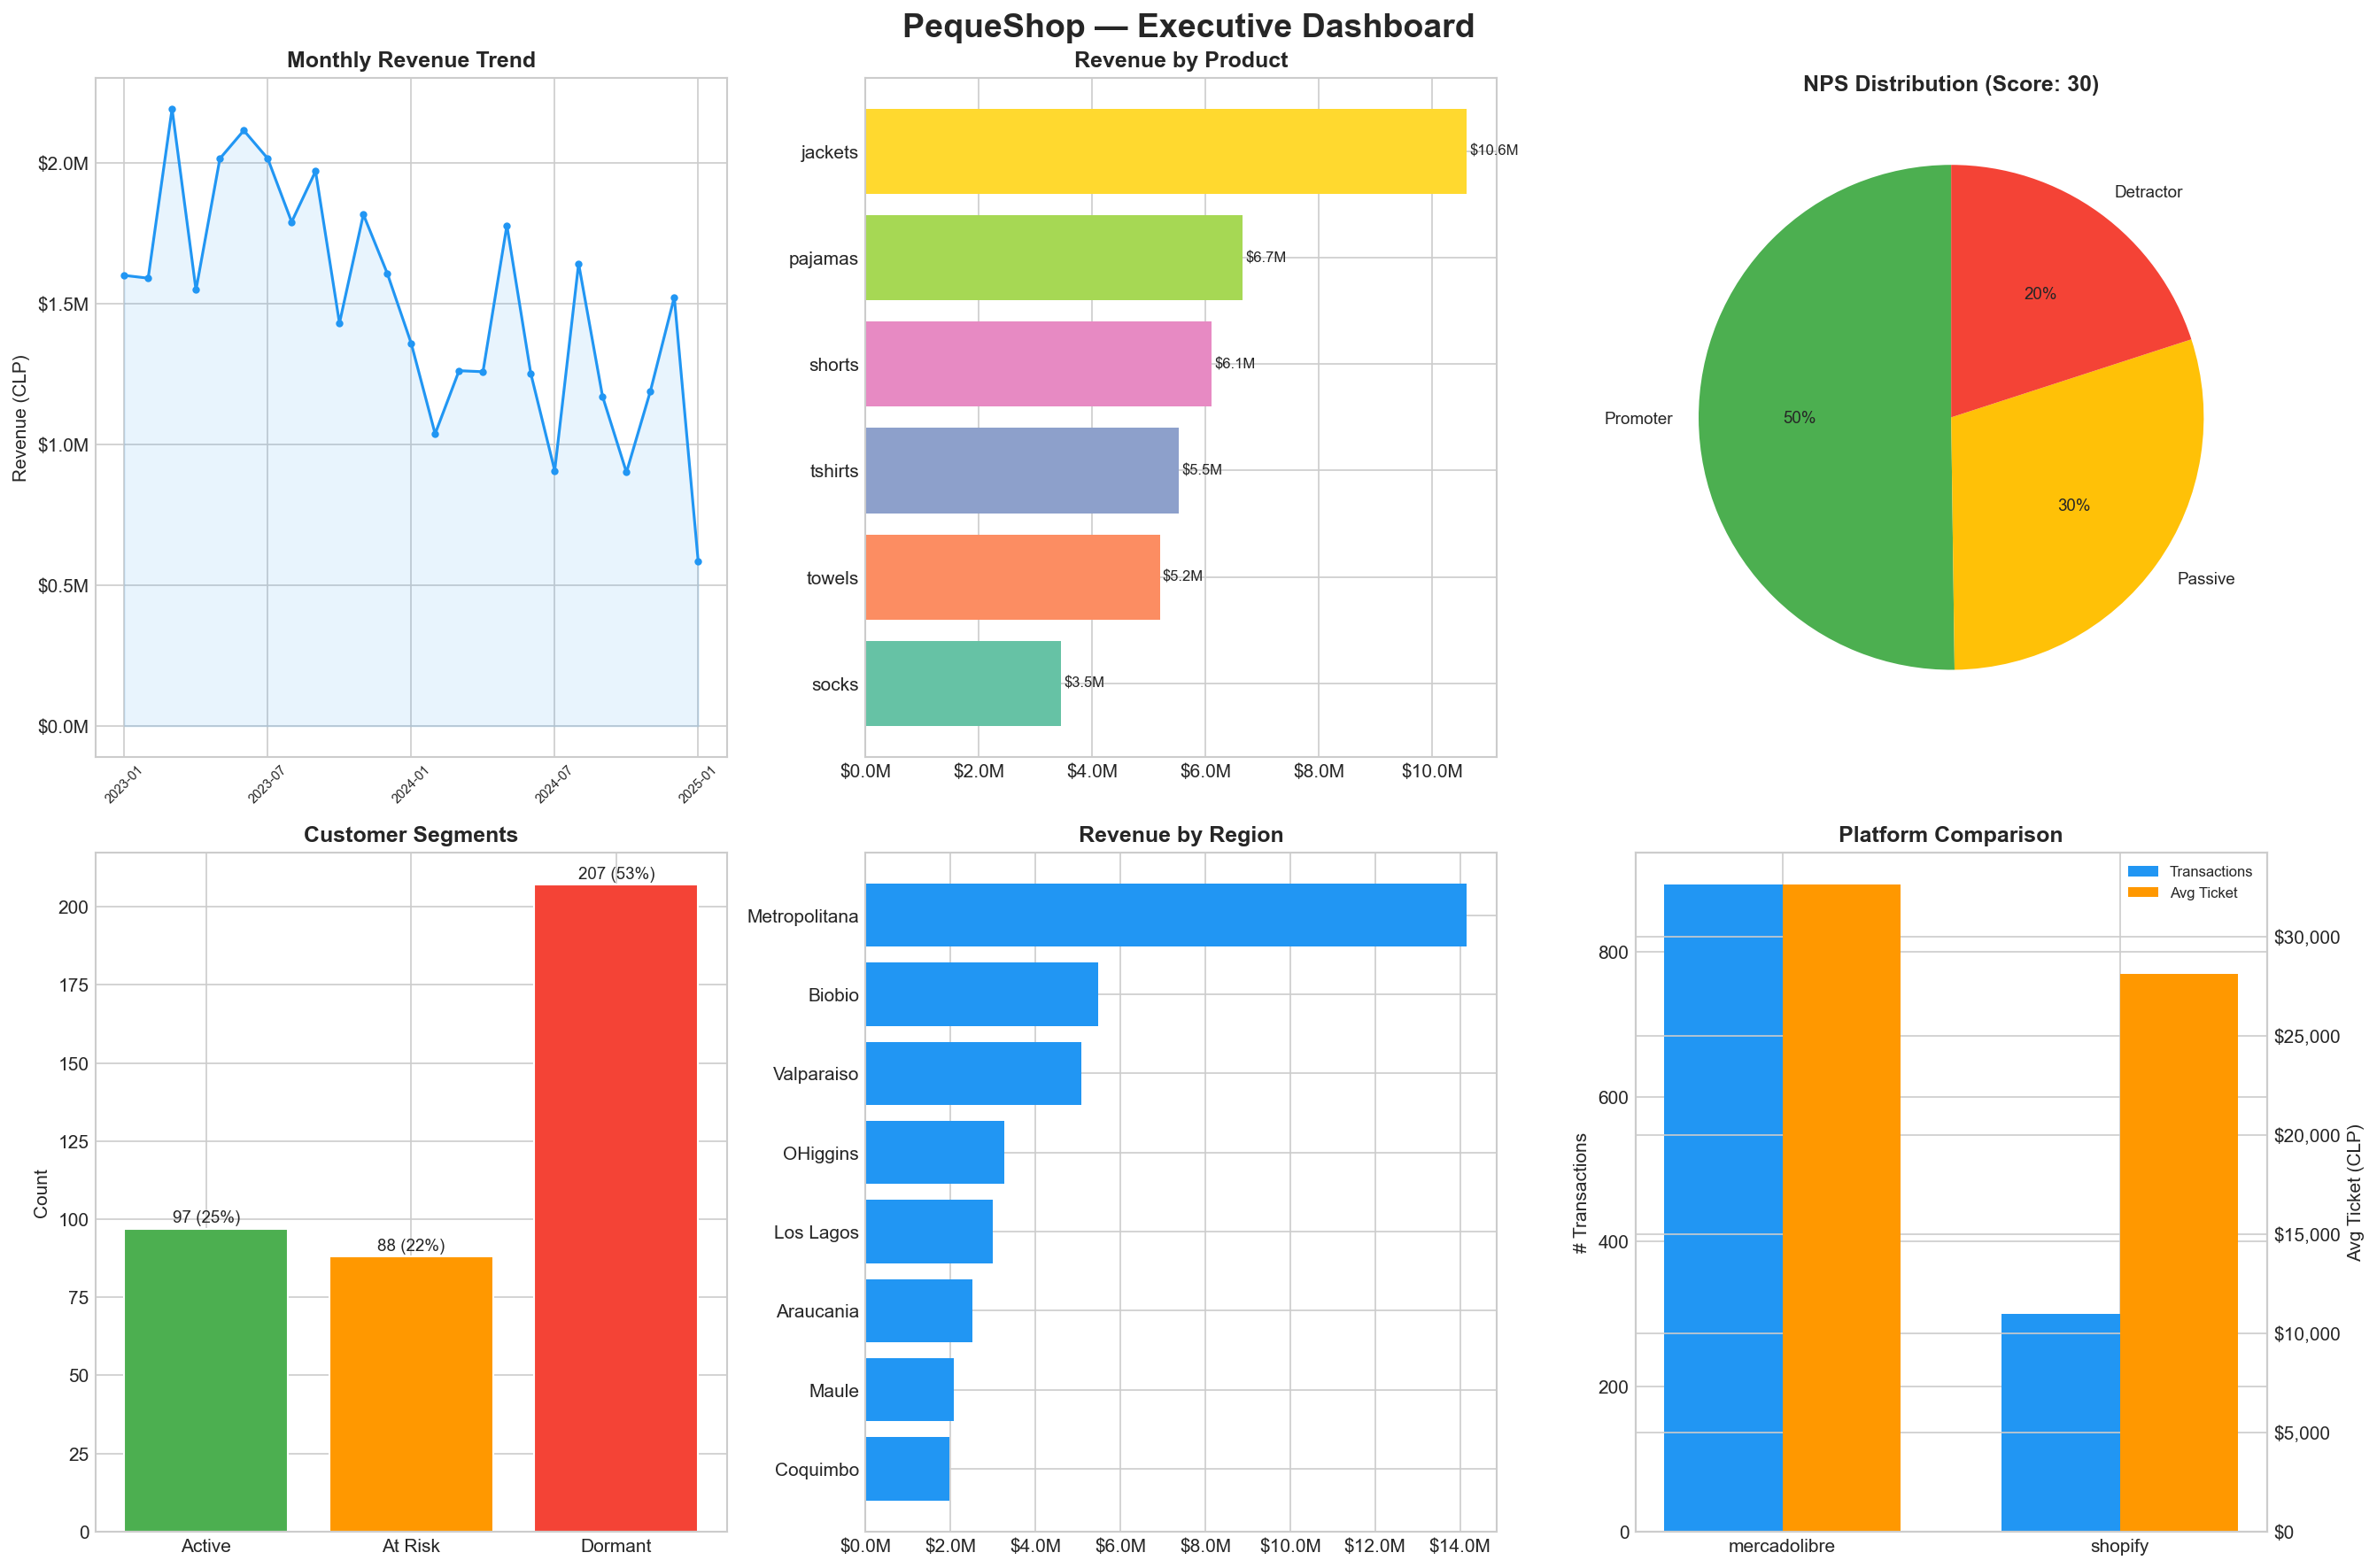

Figure saved: reports/figures/executive_dashboard.png


In [9]:
# =============================================================================
# EXECUTIVE DASHBOARD — 6-PANEL OVERVIEW
# =============================================================================

fig = plt.figure(figsize=(18, 12))
fig.suptitle('PequeShop — Executive Dashboard',
             fontsize=18, fontweight='bold', y=0.98)

# --- Panel 1: Monthly Revenue Trend ---
ax1 = fig.add_subplot(2, 3, 1)
monthly_rev = (
    df_transactions
    .groupby(df_transactions['transaction_date'].dt.to_period('M'))
    ['total_amount'].sum()
)
monthly_rev.index = monthly_rev.index.astype(str)
ax1.plot(range(len(monthly_rev)), monthly_rev.values, marker='o',
         markersize=3, linewidth=1.5, color='#2196F3')
ax1.fill_between(range(len(monthly_rev)), monthly_rev.values, alpha=0.1,
                 color='#2196F3')
ax1.set_title('Monthly Revenue Trend', fontweight='bold')
ax1.set_ylabel('Revenue (CLP)')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x/1_000_000:,.1f}M'
))
# Show only every 6th label
tick_positions = range(0, len(monthly_rev), 6)
ax1.set_xticks(list(tick_positions))
ax1.set_xticklabels([monthly_rev.index[i] for i in tick_positions],
                     rotation=45, fontsize=7)

# --- Panel 2: Revenue by Product ---
ax2 = fig.add_subplot(2, 3, 2)
product_rev = (
    df_transactions
    .groupby('product')['total_amount'].sum()
    .sort_values(ascending=True)
)
colors = sns.color_palette('Set2', len(product_rev))
ax2.barh(product_rev.index, product_rev.values, color=colors)
ax2.set_title('Revenue by Product', fontweight='bold')
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x/1_000_000:,.1f}M'
))
# Add value labels
for i, v in enumerate(product_rev.values):
    ax2.text(v + 50000, i, f'${v/1_000_000:,.1f}M', va='center', fontsize=8)

# --- Panel 3: NPS Distribution ---
ax3 = fig.add_subplot(2, 3, 3)
nps_counts = nps_respondents['nps_category'].value_counts()
nps_order = ['Promoter', 'Passive', 'Detractor']
nps_colors = ['#4CAF50', '#FFC107', '#F44336']
nps_vals = [nps_counts.get(cat, 0) for cat in nps_order]
ax3.pie(nps_vals, labels=nps_order, colors=nps_colors, autopct='%1.0f%%',
        startangle=90, textprops={'fontsize': 9})
# Calculate NPS score
total_resp = sum(nps_vals)
nps_score = (nps_vals[0] - nps_vals[2]) / total_resp * 100
ax3.set_title(f'NPS Distribution (Score: {nps_score:.0f})', fontweight='bold')

# --- Panel 4: Customer Segments ---
ax4 = fig.add_subplot(2, 3, 4)
seg_counts = active_customers['retargeting_segment'].value_counts()
seg_order = ['Active', 'At Risk', 'Dormant']
seg_colors = ['#4CAF50', '#FF9800', '#F44336']
seg_vals = [seg_counts.get(s, 0) for s in seg_order]
bars = ax4.bar(seg_order, seg_vals, color=seg_colors, edgecolor='white')
ax4.set_title('Customer Segments', fontweight='bold')
ax4.set_ylabel('Count')
# Add count labels
for bar, val in zip(bars, seg_vals):
    ax4.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             f'{val} ({val/sum(seg_vals)*100:.0f}%)',
             ha='center', fontsize=9)

# --- Panel 5: Top Regions by Revenue ---
ax5 = fig.add_subplot(2, 3, 5)
region_rev = (
    active_customers
    .groupby('region')['total_revenue'].sum()
    .sort_values(ascending=True)
)
ax5.barh(region_rev.index, region_rev.values, color='#2196F3')
ax5.set_title('Revenue by Region', fontweight='bold')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x/1_000_000:,.1f}M'
))

# --- Panel 6: Platform Comparison ---
ax6 = fig.add_subplot(2, 3, 6)
platform_stats = (
    df_transactions
    .groupby('platform')
    .agg(
        transactions=('total_amount', 'count'),
        revenue=('total_amount', 'sum'),
        avg_ticket=('total_amount', 'mean')
    )
)
x_pos = range(len(platform_stats))
width = 0.35
bars1 = ax6.bar([p - width/2 for p in x_pos],
                platform_stats['transactions'],
                width, label='Transactions', color='#2196F3')
ax6_twin = ax6.twinx()
bars2 = ax6_twin.bar([p + width/2 for p in x_pos],
                     platform_stats['avg_ticket'],
                     width, label='Avg Ticket', color='#FF9800')
ax6.set_xticks(list(x_pos))
ax6.set_xticklabels(platform_stats.index)
ax6.set_ylabel('# Transactions')
ax6_twin.set_ylabel('Avg Ticket (CLP)')
ax6_twin.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x:,.0f}'
))
ax6.set_title('Platform Comparison', fontweight='bold')
# Combined legend
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

plt.tight_layout()
fig.savefig(FIGURES / 'executive_dashboard.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/executive_dashboard.png')

### 5.2.2 Annotated Regression Plot

Custom Matplotlib visualization combining Seaborn regression  
with manual annotations and formatting.

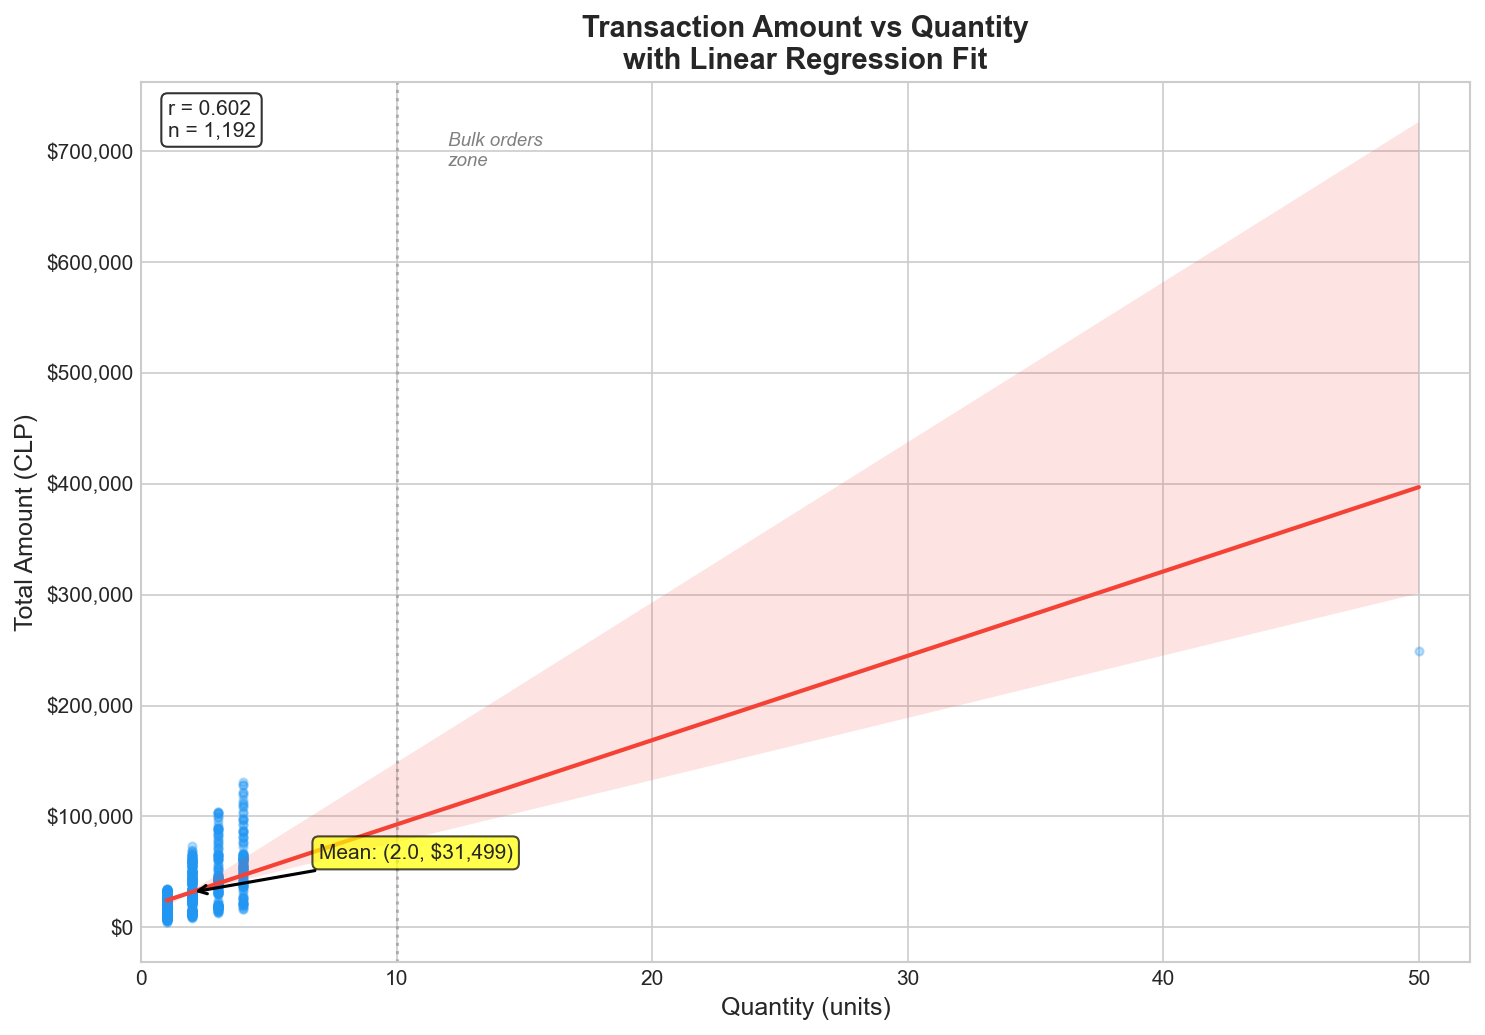

Figure saved: reports/figures/regression_annotated.png


In [10]:
# =============================================================================
# ANNOTATED REGRESSION — SEABORN + MATPLOTLIB COMBINED
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 7))

# Seaborn regression
sns.regplot(
    data=df_transactions,
    x='quantity',
    y='total_amount',
    scatter_kws={'alpha': 0.3, 's': 15, 'color': '#2196F3'},
    line_kws={'color': '#F44336', 'linewidth': 2},
    ax=ax
)

# Matplotlib customization
ax.set_title('Transaction Amount vs Quantity\nwith Linear Regression Fit',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Quantity (units)', fontsize=12)
ax.set_ylabel('Total Amount (CLP)', fontsize=12)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x:,.0f}'
))

# Annotation: mean point
mean_qty = df_transactions['quantity'].mean()
mean_amt = df_transactions['total_amount'].mean()
ax.annotate(
    f'Mean: ({mean_qty:.1f}, ${mean_amt:,.0f})',
    xy=(mean_qty, mean_amt),
    xytext=(mean_qty + 5, mean_amt + 30000),
    fontsize=10,
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
)

# Annotation: bulk orders zone
ax.axvline(x=10, color='gray', linestyle=':', alpha=0.5)
ax.text(12, ax.get_ylim()[1] * 0.9, 'Bulk orders\nzone',
        fontsize=9, color='gray', style='italic')

# Stats box
r = df_transactions[['quantity', 'total_amount']].corr().iloc[0, 1]
stats_text = f'r = {r:.3f}\nn = {len(df_transactions):,}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Axis limits
ax.set_xlim(0, df_transactions['quantity'].max() + 2)

plt.tight_layout()
fig.savefig(FIGURES / 'regression_annotated.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/regression_annotated.png')

### 5.2.3 Custom Multi-Panel Figure — KPI Summary

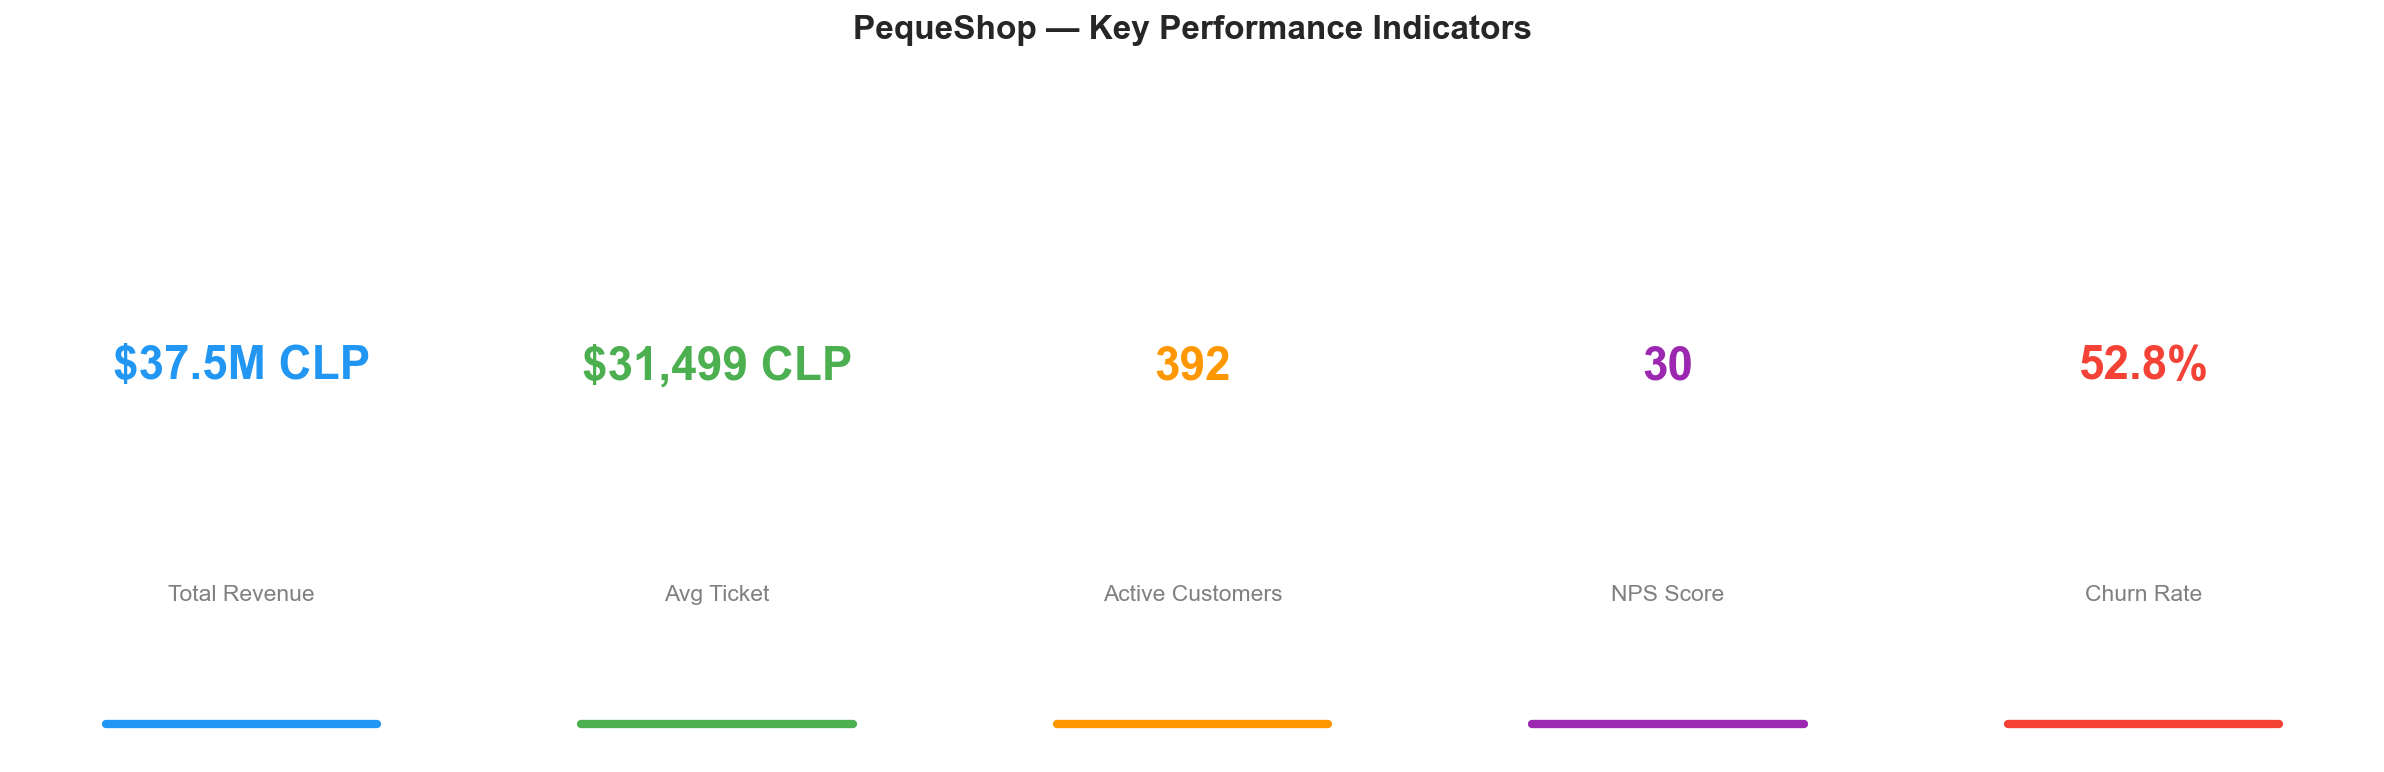

Figure saved: reports/figures/kpi_summary.png


In [11]:
# =============================================================================
# KPI SUMMARY FIGURE WITH CUSTOM LAYOUT
# =============================================================================

fig = plt.figure(figsize=(16, 5))

# KPI metrics
total_revenue = df_transactions['total_amount'].sum()
avg_ticket = df_transactions['total_amount'].mean()
total_customers = len(active_customers)
churn_rate = (
    active_customers['retargeting_segment']
    .value_counts(normalize=True)
    .get('Dormant', 0) * 100
)

kpis = [
    ('Total Revenue', f'${total_revenue/1_000_000:,.1f}M CLP', '#2196F3'),
    ('Avg Ticket', f'${avg_ticket:,.0f} CLP', '#4CAF50'),
    ('Active Customers', f'{total_customers}', '#FF9800'),
    ('NPS Score', f'{nps_score:.0f}', '#9C27B0'),
    ('Churn Rate', f'{churn_rate:.1f}%', '#F44336')
]

for i, (title, value, color) in enumerate(kpis):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.text(0.5, 0.6, value, ha='center', va='center',
            fontsize=22, fontweight='bold', color=color,
            transform=ax.transAxes)
    ax.text(0.5, 0.25, title, ha='center', va='center',
            fontsize=11, color='gray', transform=ax.transAxes)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    # Bottom color bar
    ax.axhline(y=0.05, xmin=0.2, xmax=0.8, color=color, linewidth=4)

fig.suptitle('PequeShop — Key Performance Indicators',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
fig.savefig(FIGURES / 'kpi_summary.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/kpi_summary.png')

### 5.2.4 Seasonal Analysis — Grouped Bar Chart

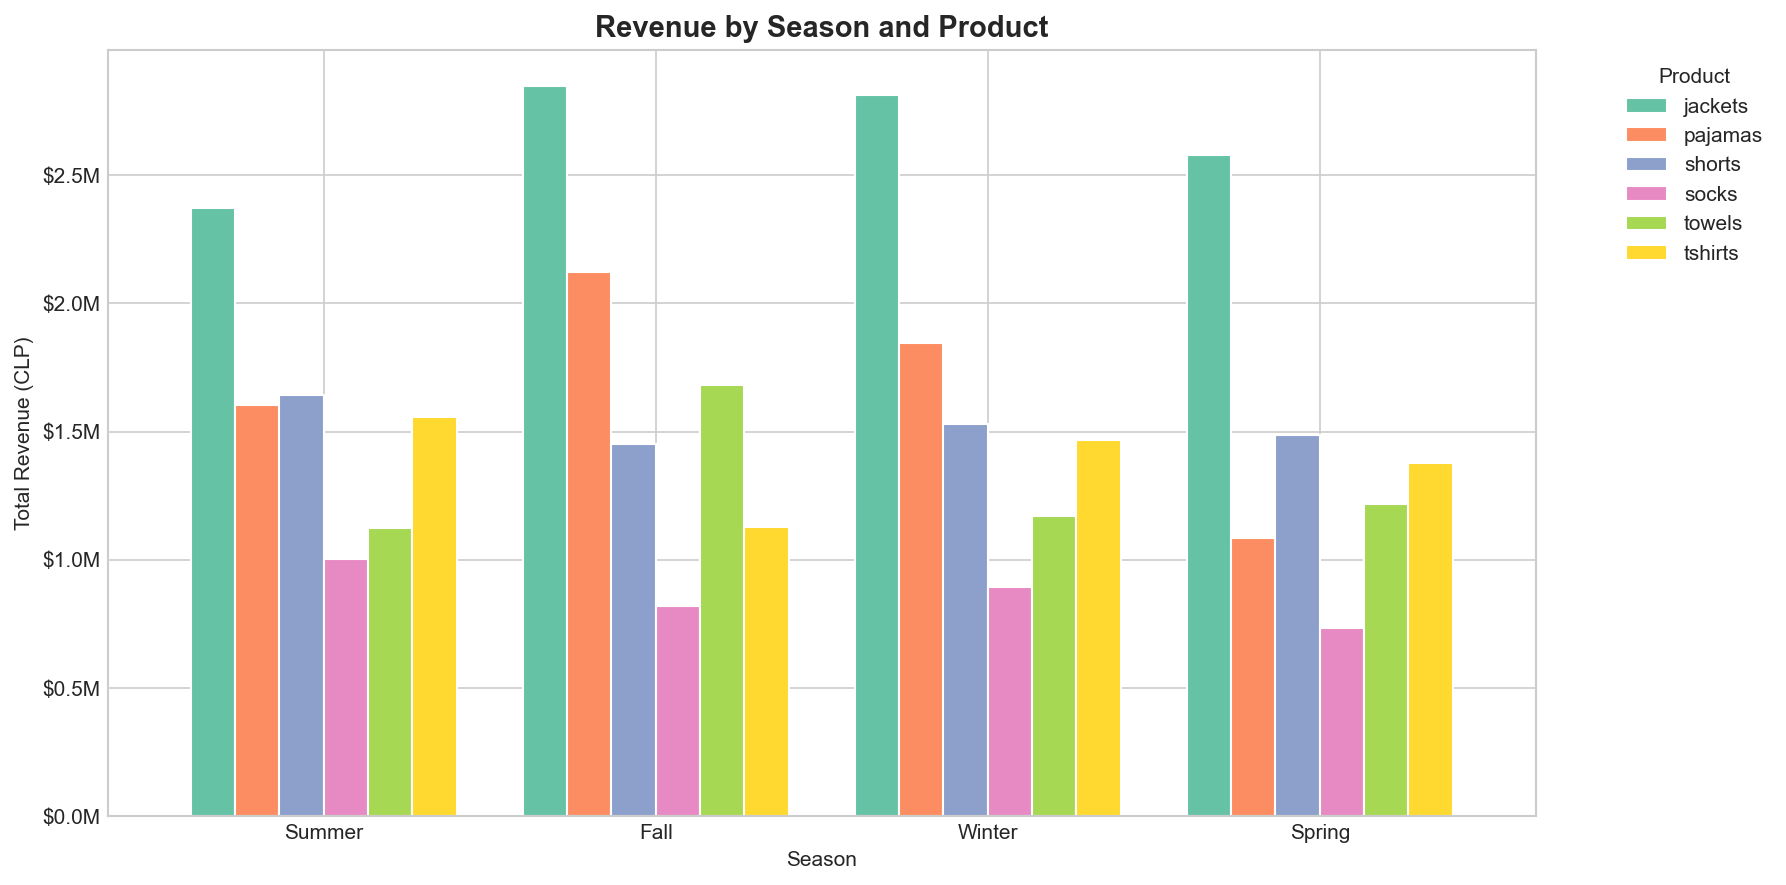

Figure saved: reports/figures/seasonal_revenue_product.png


In [12]:
# =============================================================================
# SEASONAL REVENUE BY PRODUCT — GROUPED BAR CHART
# =============================================================================

season_product = (
    df_transactions
    .groupby(['season', 'product'])['total_amount']
    .sum()
    .unstack()
)
season_order = ['Summer', 'Fall', 'Winter', 'Spring']
season_product = season_product.loc[season_order]

fig, ax = plt.subplots(figsize=(12, 6))
season_product.plot(kind='bar', ax=ax, width=0.8, edgecolor='white')

ax.set_title('Revenue by Season and Product',
             fontsize=14, fontweight='bold')
ax.set_ylabel('Total Revenue (CLP)')
ax.set_xlabel('Season')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, p: f'${x/1_000_000:,.1f}M'
))
ax.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
fig.savefig(FIGURES / 'seasonal_revenue_product.png',
            bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/seasonal_revenue_product.png')

### 5.2.5 Export All Key Figures

All figures have been saved individually throughout the notebook.  
Final inventory of exported visualizations:

In [13]:
# =============================================================================
# FIGURE INVENTORY
# =============================================================================

import os

figures_dir = FIGURES
if figures_dir.exists():
    files = sorted(figures_dir.glob('*.png'))
    print(f'EXPORTED FIGURES ({len(files)} files)')
    print('=' * 60)
    for f in files:
        size_kb = f.stat().st_size / 1024
        print(f'  {f.name:<45} {size_kb:>6.0f} KB')
else:
    print('Figures directory not found. Run all cells first.')

EXPORTED FIGURES (16 files)
  boxplots_outliers.png                            104 KB
  channel_analysis.png                              59 KB
  correlation_matrix_customers.png                  85 KB
  correlation_matrix_transactions.png               74 KB
  executive_dashboard.png                          222 KB
  facetgrid_product_regression.png                  95 KB
  heatmap_product_season.png                        88 KB
  histograms_transactions.png                       79 KB
  jointplot_price_quantity.png                      50 KB
  kpi_summary.png                                   51 KB
  pairplot_transactions.png                        275 KB
  regression_annotated.png                          98 KB
  residual_analysis.png                            178 KB
  scatterplots_relationships.png                   221 KB
  seasonal_revenue_product.png                      48 KB
  violinplots_revenue.png                          147 KB


---

## 5.3 Key Insights Summary

### For Technical Audience (English)

1. **Revenue concentration**: Transaction amounts are right-skewed,  
   confirming Pareto patterns in customer behavior.

2. **Dual revenue levers**: Both quantity (r ≈ 0.60) and unit price  
   (r ≈ 0.61) significantly predict transaction value.  
   The multiple regression model explains substantially more variance  
   than quantity alone.

3. **Platform dynamics**: MercadoLibre dominates volume (75% of  
   transactions) while Shopify may show different ticket patterns.

4. **Customer health warning**: 52.8% of active customers are Dormant,  
   22.4% At Risk — retention is the critical priority.

5. **NPS non-response bias**: 53% of customers did not respond to NPS.  
   Correlations involving NPS should be interpreted with caution.

### Para Audiencia de Negocio (Español)

1. **Concentración de ingresos**: Pocos clientes generan una parte  
   desproporcionada de los ingresos (efecto Pareto).

2. **Dos palancas de crecimiento**: Aumentar unidades por pedido  
   O migrar hacia productos premium (chaquetas, pijamas).

3. **Alerta de retención**: Más de la mitad de los clientes activos  
   están dormidos. Priorizar campañas de reactivación.

4. **Oportunidad estacional**: Analizar qué combinaciones  
   producto-temporada maximizan ingresos para planificar inventario.

---

**Previous**: [04_modeling.ipynb](./04_modeling.ipynb)  
**Next**: [06_deployment.ipynb](./06_deployment.ipynb) — Final deliverables